# Import and misc

In [ ]:
!pip install torchaudio==0.9.1

In [ ]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses
import random

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [ ]:
SEED = 123

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def set_seed():
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  random.seed(SEED)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [ ]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [6]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [7]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [8]:
dataset.csv.sample(5)

,path,keyword,label
12122,speech_commands/house/890e4ee2_nohash_0.wav,house,0
7939,speech_commands/yes/cb2929ce_nohash_2.wav,yes,0
4292,speech_commands/five/682e1687_nohash_0.wav,five,0
60641,speech_commands/cat/7117fb6d_nohash_3.wav,cat,0
7940,speech_commands/yes/f632210f_nohash_1.wav,yes,0


### Augmentations

In [9]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [10]:
# Для воспроизводимости
set_seed()

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [11]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config, device):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig, device=TaskConfig.device)
melspec_val = LogMelspec(is_train=False, config=TaskConfig, device=TaskConfig.device)

### Quality measurment functions:

In [18]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [19]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model Summary

In [20]:
!pip install thop

# Doesn't work with quantized models
from thop import profile


def get_size_in_kbytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 10)

def model_summary(model):
    kb = get_size_in_kbytes(model)
    macs = profile(model, (torch.rand(1, 40, 200), ))
    to_print = f'\nKBytes: {kb: .3f}\nMACs: {macs[0]}\nNumber of parameters: {macs[1]}'
    print(to_print)

# Model

In [21]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2), energy, alpha

class BaseModel(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector, energy, alpha = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output, energy, alpha # for attention distillation

In [22]:
def plot_metrics(history):
  clear_output()
  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  plt.plot(history['val_metric'])
  plt.ylabel('AU FA FR')
  plt.xlabel('Epoch')
  plt.grid()
  plt.subplot(1, 2, 2)
  plt.plot(history['val_acc'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.show()

def simple_train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in enumerate(tqdm(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits, _, _ = model(batch)
        # we need probabilities so we use softmax & CE separately
        # probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

In [23]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in enumerate(tqdm(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output, _, _ = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    acc = torch.mean(torch.tensor(accs)).item()
    return au_fa_fr, acc, FAs

In [24]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [25]:
def simple_train(model, opt):
  history = defaultdict(list)
  best_metric = 1.
  for n in range(TaskConfig.num_epochs):
      simple_train_epoch(model, opt, train_loader,
                  melspec_train, TaskConfig.device)

      au_fa_fr, acc, FAs = validation(model, val_loader,
                          melspec_val, TaskConfig.device)
      if au_fa_fr < best_metric:
          best_metric = au_fa_fr
          torch.save(model.state_dict(), 'best_base_model.pt')
      history['val_metric'].append(au_fa_fr)
      history['val_acc'].append(acc)
      plot_metrics(history)
      print(best_metric)
  model.load_state_dict(torch.load('best_base_model.pt'))
  return best_metric

# Training

In [26]:
set_seed()

config = TaskConfig()
base_model = BaseModel(config).to(config.device)

print(base_model)

opt = torch.optim.Adam(
    base_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

BaseModel(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [27]:
model_summary(BaseModel(TaskConfig))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.BaseModel'>. Treat it as zero Macs and zero Params.

KBytes:  275.168
MACs: 1952368.0
Number of parameters: 70443.0


То есть нужно добиться < 7045 параметров и < 195236 MACs.

In [86]:
# запусти ячейку, чтобы скачать веса

# !gdown -O weights.pt https://drive.google.com/uc?id=12FHzJRLIWxq5bQFa9IDOEuqFfkz1q5Ic
# base_model = BaseModel(TaskConfig).to(TaskConfig.device)
# base_model.load_state_dict(torch.load('weights.pt'))

Downloading...
From: https://drive.google.com/uc?id=12FHzJRLIWxq5bQFa9IDOEuqFfkz1q5Ic
To: /content/weights.pt
100% 285k/285k [00:00<00:00, 84.8MB/s]


<All keys matched successfully>

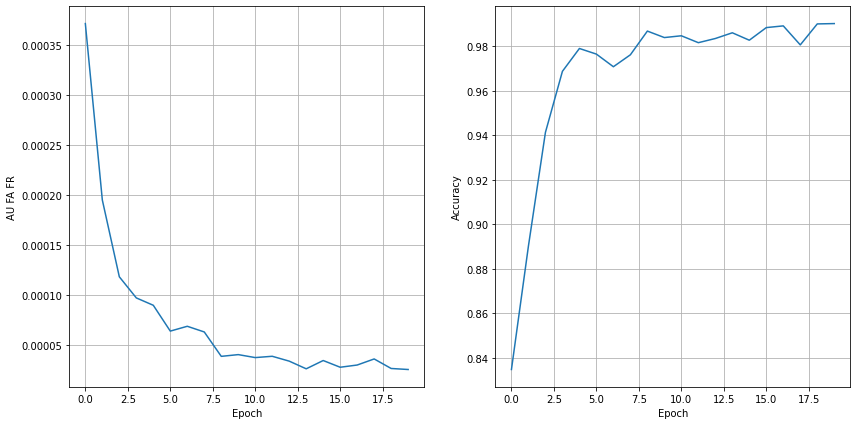

2.6006572358528466e-05


In [ ]:
# TRAIN
best_base_metric = simple_train(base_model, opt)

Явно модель может ещё лучше, но ладно...

In [ ]:
# работает только после запуска трейнлупа,
# не нужно запускать, если качаешь веса

base_model.load_state_dict(torch.load('best_base_model.pt'))

<All keys matched successfully>

In [ ]:
best_base_metric, _, _ = validation(base_model, val_loader, melspec_val, 'cuda')

100%|██████████| 102/102 [00:05<00:00, 17.77it/s]


In [ ]:
print(f'Best Base AU FA FR: {best_base_metric: .7f}')

Best Base AU FA FR:  0.0000260


In [102]:
# Определим словарь с описанием и результатами моделей

model_summaries = {}

model_summaries['B'] = {
    'MACs': 1952368,
    'Parameters': 70443,
    'Theoretical size (KB)': 275.168,
    'Real size (KB)': 278.51, # смотрим размер сохраненного state_dict
    'Metric': 0.0000260
}

# Streaming

In [155]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input):
        # input: (batch, seq_len, channels)
        energy = self.energy(input)
        # energy: (batch, seq_len, 1)
        alpha = torch.softmax(energy, dim=-2)
        # alpha: (batch, seq_len, 1)
        return (input * alpha).sum(dim=-2), energy, alpha

    # FOR STREAMING
    def inference(self, input):
        # input: (batch, seq_len, channels)
        energy = self.energy(input)
        # energy: (batch, seq_len, 1)
        return energy

class StreamingBaseModel(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
        
        # FOR STREAMING
        self.inference_hidden = None
        self.inference_energies = None
        self.inference_hiddens = None

    def forward(self, input):
        # input: (batch, num_feats, seq_len)
        input = input.unsqueeze(dim=1)
        # input: (batch, 1, num_feats, seq_len)
        conv_output = self.conv(input).transpose(-1, -2)
        # conv_output: (batch, seq_len, channels)
        gru_output, _ = self.gru(conv_output)
        # gru_output: (batch, seq_len, channels)
        contex_vector, energy, alpha = self.attention(gru_output)
        # contex_vector: (batch, channels)
        output = self.classifier(contex_vector)
        # output: (batch, num_classes)
        return output, energy, alpha

    ########## STREAM MODE ##########

    def inference(self, chunk, max_buffer_len=24):
        # chunk: (1, num_feat, seq_len)
        chunk = self.conv(chunk.unsqueeze(0)).transpose(-1, -2)
        # chunk: (1, hidden, seq_len)
        chunk, self.inference_hidden = self.gru(chunk, self.inference_hidden)
        # chunk: (1, seq_len, hidden)
        now_energies = self.attention.inference(chunk)
        # now_energies: (1, seq_len, 1)
        if self.inference_energies is not None:
            to_forget = max_buffer_len - self.inference_energies.shape[1] - now_energies.shape[1]
            if to_forget < 0:
                # forget
                self.inference_energies = self.inference_energies[:, abs(to_forget):, :]
                self.inference_hiddens = self.inference_hiddens[:, abs(to_forget):, :]
            self.inference_energies = torch.cat([self.inference_energies, now_energies], dim=1)
            self.inference_hiddens = torch.cat([self.inference_hiddens, chunk], dim=1)
        else:
            self.inference_energies = now_energies
            self.inference_hiddens = chunk
        alphas = torch.softmax(self.inference_energies, dim=-2)
        # alphas: (1, seq_len, 1)
        context = (self.inference_hiddens * alphas).sum(dim=-2)
        # context: (1, channels)
        result = self.classifier(context)
        # result: (1, num_classes)
        return result

In [156]:
# Load weights from base model

streaming_model = StreamingBaseModel(TaskConfig)
streaming_model.load_state_dict(base_model.state_dict())
streaming_model.to(TaskConfig.device)

StreamingBaseModel(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [157]:
# 1 second -> 100 (logmel)
# 1 second -> ~ 11-13 frames (after conv)

Проверим модель на стриминг. Для этого загрузим ~10 секунд речи из LJ и законкатенируем её спереди и сзади к команде. Затемм посмотрим на график вероятности ключевого слова. 

Ожидаем, что в середине записи будет куполообразное увеличение, а затем уменьшение вероятности ключевого слова.

In [158]:
!wget https://github.com/erasedwalt/CTC-ASR/raw/main/one_batch/wavs/LJ001-0001.wav

--2021-11-21 12:46:00--  https://github.com/erasedwalt/CTC-ASR/raw/main/one_batch/wavs/LJ001-0001.wav
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erasedwalt/CTC-ASR/main/one_batch/wavs/LJ001-0001.wav [following]
--2021-11-21 12:46:00--  https://raw.githubusercontent.com/erasedwalt/CTC-ASR/main/one_batch/wavs/LJ001-0001.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 425830 (416K) [audio/wav]
Saving to: ‘LJ001-0001.wav’

LJ001-0001.wav      100%[===================>] 415.85K  --.-KB/s    in 0.04s   

2021-11-21 12:46:01 (9.77 MB/s) - ‘LJ001-0001.wav’ saved [425830/425830]



In [159]:
# Грузим и предобрабатываем речь

effects = [['channels', '1'], ['rate', '16000']]
a, r = torchaudio.sox_effects.apply_effects_file('/content/LJ001-0001.wav', effects)
speech_melspec = melspec_val(a.cuda())

In [160]:
# Берём аудиозапись с ключевым словом и конкатенируем

x = next(iter(val_loader))
idx = np.where(x[1] == 1)[0][0]
command_melspec = melspec_val(x[0][idx].unsqueeze(0).cuda())

all_melspec = torch.cat([speech_melspec, command_melspec, speech_melspec], dim=2).squeeze()
# all_melspec: (40, seq_len)
# тут отбрасывается конец записи, если длина не делится на 100
all_melspec = all_melspec.unfold(1, 100, 100).transpose(0, 1)
# all_melspec: (seq_len // 100, 40, 100) где 100 - примерно 1 секунда

In [161]:
probs = []
with torch.no_grad():
  streaming_model.eval()
  for i in range(all_melspec.shape[0]):
    # размер буфера - 24 - примерно 2 секунды
    p = streaming_model.inference(all_melspec[i].unsqueeze(0), 24).softmax(dim=1)[0, 1].item()
    probs.append(p)

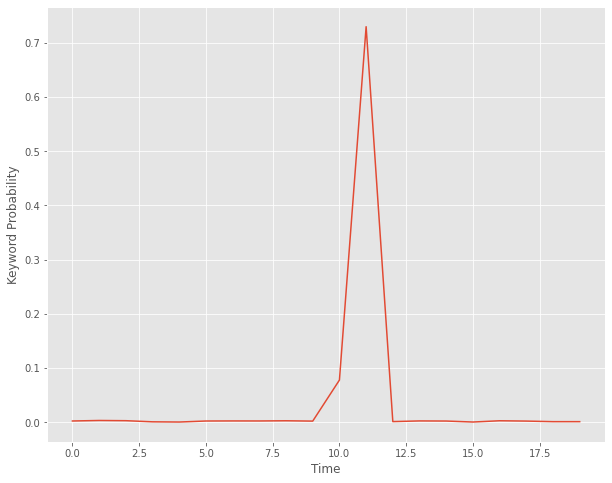

In [163]:
plt.figure(figsize=(10, 8))
plt.plot(probs)
plt.xlabel('Time')
plt.ylabel('Keyword Probability')
plt.show()

Работает как надо.

# Dark Knowledge Distillation

In [36]:
def dark_knowledge_distillation_train_epoch(model, teacher, opt, loader,
                                            log_melspec, device, alpha=0.95, T=2):
    model.train()
    teacher.eval()
    for i, (batch, labels) in enumerate(tqdm(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits, _, _ = model(batch)
        with torch.no_grad():
            teacher_logits, _, _ = teacher(batch)

        loss = nn.KLDivLoss()(F.log_softmax(logits / T, dim=1), 
                              F.softmax(teacher_logits / T, dim=1)) * (alpha * T ** 2)
        loss += F.cross_entropy(logits, labels) * (1. - alpha)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()


def dark_knowledge_distillation_train(model, teacher, opt):
  history = defaultdict(list)
  best_metric = 1.
  for n in range(400):
      dark_knowledge_distillation_train_epoch(model, teacher, opt, train_loader,
                  melspec_train, TaskConfig.device)

      au_fa_fr, acc, FAs = validation(model, val_loader,
                          melspec_val, TaskConfig.device)
      if au_fa_fr < best_metric:
          best_metric = au_fa_fr
          torch.save(model.state_dict(), 'best_distill_model.pt')
      history['val_metric'].append(au_fa_fr)
      history['val_acc'].append(acc)
      plot_metrics(history)
      print(best_metric)
  model.load_state_dict(torch.load('best_distill_model.pt'))
  return best_metric

In [37]:
# Уменьшим количество каналов в свертке в два раза
# и hidden_size в три раза
# и размер ядра в свертке с 20 на 15 (только по одной оси)

class DistillModel(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels // 2,
                kernel_size=(15, 5), stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - 15) // \
            config.stride[0] + 1

        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * (config.cnn_out_channels // 2),
            hidden_size=config.hidden_size // 3,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size // 3)
        self.classifier = nn.Linear(config.hidden_size // 3, config.num_classes)

    def forward(self, input):
        # input: (batch, num_feats, seq_len)
        input = input.unsqueeze(dim=1)
        # input: (batch, 1, num_feats, seq_len)
        conv_output = self.conv(input).transpose(-1, -2)
        # conv_output: (batch, seq_len, channels)
        gru_output, _ = self.gru(conv_output)
        # gru_output: (batch, seq_len, channels)
        contex_vector, energy, alpha = self.attention(gru_output)
        # contex_vector: (batch, channels)
        output = self.classifier(contex_vector)
        # output: (batch, num_classes)
        return output, energy, alpha

In [38]:
model_summary(DistillModel(TaskConfig))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DistillModel'>. Treat it as zero Macs and zero Params.

KBytes:  32.535
MACs: 305167.0
Number of parameters: 8329.0


Эта модель в ~8.4 раз меньше и в ~6.4 раз быстрее.

In [39]:
set_seed()

config = TaskConfig()
distill_model = DistillModel(config).to(config.device)

print(distill_model)

opt = torch.optim.Adam(
    distill_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

DistillModel(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(15, 5), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(52, 21, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=21, out_features=21, bias=True)
      (1): Tanh()
      (2): Linear(in_features=21, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=21, out_features=2, bias=True)
)


In [41]:
# запусти ячейку, чтобы скачать веса

# !gdown -O weights.pt https://drive.google.com/uc?id=1-02tWOG3fwVjWRU_qthLXCWtUKqUhJtT
# distill_model = DistillModel(TaskConfig).to(TaskConfig.device)
# distill_model.load_state_dict(torch.load('weights.pt'))

Downloading...
From: https://drive.google.com/uc?id=1-02tWOG3fwVjWRU_qthLXCWtUKqUhJtT
To: /content/weights.pt
100% 36.9k/36.9k [00:00<00:00, 4.97MB/s]


<All keys matched successfully>

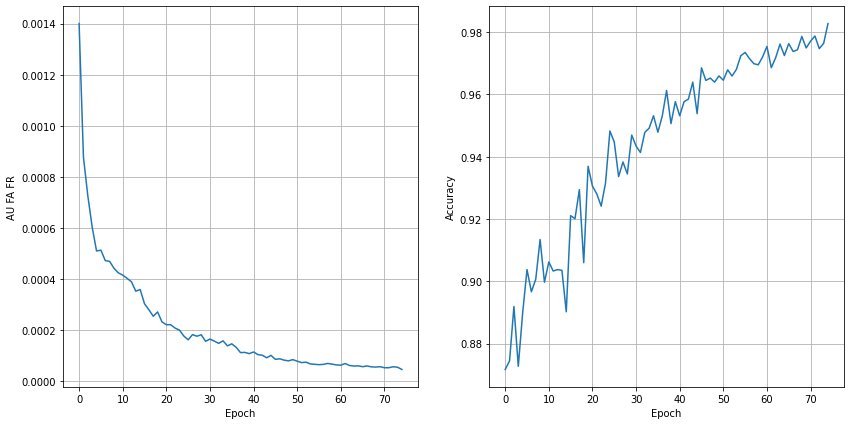

4.5932213731893905e-05


 15%|█▌        | 61/405 [00:06<00:36,  9.39it/s]


KeyboardInterrupt: ignored

In [ ]:
best_distill_metric = dark_knowledge_distillation_train(distill_model, base_model, opt)

In [ ]:
# не нужно тыкать, если скачал веса

distill_model.load_state_dict(torch.load('/content/best_distill_model.pt'))

<All keys matched successfully>

In [ ]:
best_distill_metric, _, _ = validation(distill_model, val_loader, melspec_val, 'cuda')

100%|██████████| 102/102 [00:05<00:00, 18.46it/s]


In [ ]:
print(f'Best Distillation AU FA FR: {best_distill_metric: .7f}')

Best Distillation AU FA FR:  0.0000459


In [103]:
model_summaries['KD'] = {
    'MACs': 305167,
    'Parameters': 8329,
    'Theoretical size (KB)': 32.535,
    'Real size (KB)': 36.07,
    'Metric': 0.0000459
}

In [104]:
model_summaries

{'B': {'MACs': 1952368,
  'Metric': 2.6e-05,
  'Parameters': 70443,
  'Real size (KB)': 278.51,
  'Theoretical size (KB)': 275.168},
 'KD': {'MACs': 305167,
  'Metric': 4.59e-05,
  'Parameters': 8329,
  'Real size (KB)': 36.07,
  'Theoretical size (KB)': 32.535}}

# Dark Knowledge Distillation + Dynamic Quantization

In [ ]:
dynamic_quant_distill_model = torch.quantization.quantize_dynamic(
    distill_model.cpu(), 
    {nn.GRU, nn.Linear},
    dtype=torch.qint8
)

In [ ]:
torch.save(dynamic_quant_distill_model.state_dict(), 'dynamic_quant_distill_model.pt')

In [70]:
# Квантизованные модели работают только на CPU

cpu_melspec = LogMelspec(is_train=False, config=TaskConfig(), device='cpu')

In [ ]:
dynamic_quant_distill_metric, _, _ = validation(
    dynamic_quant_distill_model, 
    val_loader,
    cpu_melspec,
    'cpu'
)

100%|██████████| 102/102 [00:09<00:00, 10.93it/s]


In [ ]:
print(f'Best Distillation + Dynamic Quantization AU FA FR: {dynamic_quant_distill_metric: .7f}')

Best Distillation + Dynamic Quantization AU FA FR:  0.0000461


In [105]:
model_summaries['DQ+KD'] = {
    'MACs': 305167, # считаем, что такое же, как и до квантизации
    'Parameters': 8329, # аналогично
    'Real size (KB)': 16.72,
    'Metric': 0.0000461
}

In [106]:
model_summaries

{'B': {'MACs': 1952368,
  'Metric': 2.6e-05,
  'Parameters': 70443,
  'Real size (KB)': 278.51,
  'Theoretical size (KB)': 275.168},
 'DQ+KD': {'MACs': 305167,
  'Metric': 4.61e-05,
  'Parameters': 8329,
  'Real size (KB)': 16.72},
 'KD': {'MACs': 305167,
  'Metric': 4.59e-05,
  'Parameters': 8329,
  'Real size (KB)': 36.07,
  'Theoretical size (KB)': 32.535}}

Уже получилось сжать в 278.51 / 16.72 ~= 16.7 раз. 

# Dark Knowledge Distillation 2

In [52]:
# Уменьшим количество каналов в свертке в два раза
# и hidden_size в пять раза
# и размер ядра в свертке с 20 на 13 (только по одной оси)

class DistillModel2(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels // 2,
                kernel_size=(13, 5), stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - 13) // \
            config.stride[0] + 1

        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * (config.cnn_out_channels // 2),
            hidden_size=config.hidden_size // 5,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size // 5)
        self.classifier = nn.Linear(config.hidden_size // 5, config.num_classes)

    def forward(self, input):
        # input: (batch, num_feats, seq_len)
        input = input.unsqueeze(dim=1)
        # input: (batch, 1, num_feats, seq_len)
        conv_output = self.conv(input).transpose(-1, -2)
        # conv_output: (batch, seq_len, channels)
        gru_output, _ = self.gru(conv_output)
        # gru_output: (batch, seq_len, channels)
        contex_vector, energy, alpha = self.attention(gru_output)
        # contex_vector: (batch, channels)
        output = self.classifier(contex_vector)
        # output: (batch, num_classes)
        return output, energy, alpha

In [53]:
model_summary(DistillModel2(TaskConfig))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DistillModel2'>. Treat it as zero Macs and zero Params.

KBytes:  15.293
MACs: 186924.0
Number of parameters: 3915.0


In [54]:
set_seed()

config = TaskConfig()
distill_model_2 = DistillModel2(config).to(config.device)

print(distill_model_2)

opt = torch.optim.Adam(
    distill_model_2.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

DistillModel2(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(13, 5), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(56, 12, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): Tanh()
      (2): Linear(in_features=12, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)


In [57]:
# запусти ячейку, чтобы скачать веса

# !gdown -O weights.pt https://drive.google.com/uc?id=1-1DHkuwd8_NlNB4SOH7lcz12LANwCQ-K
# distill_model_2 = DistillModel2(TaskConfig).to(TaskConfig.device)
# distill_model_2.load_state_dict(torch.load('weights.pt'))

Downloading...
From: https://drive.google.com/uc?id=1-1DHkuwd8_NlNB4SOH7lcz12LANwCQ-K
To: /content/weights.pt
100% 19.2k/19.2k [00:00<00:00, 30.2MB/s]


<All keys matched successfully>

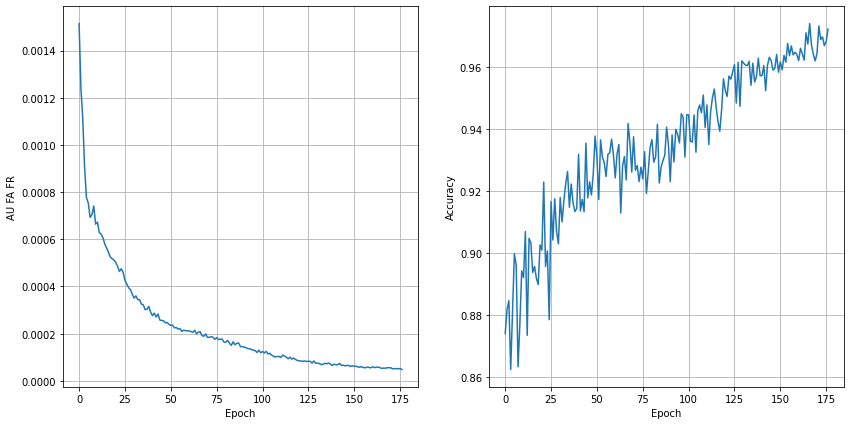

4.769264026832481e-05


  6%|▌         | 24/405 [00:02<00:43,  8.80it/s]
Exception in thread Thread-619:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process

KeyboardInterrupt: ignored

In [ ]:
best_distill_2_metric = dark_knowledge_distillation_train(distill_model_2, base_model, opt)

In [ ]:
distill_model_2.load_state_dict(torch.load('best_distill_model.pt'))

In [59]:
distill_2_metric, _, _ = validation(
    distill_model_2,
    val_loader,
    melspec_val,
    'cuda'
)

100%|██████████| 102/102 [00:05<00:00, 19.41it/s]


In [60]:
print(f'Best Distill 2 AU FA FR: {distill_2_metric: .7f}')

Best Distill 2 AU FA FR:  0.0000477


In [107]:
model_summaries['KD2'] = {
    'MACs': 186924,
    'Parameters': 3915,
    'Theoretical size (KB)': 15.293,
    'Real size (KB)': 18.76,
    'Metric': 0.0000477
}

In [108]:
model_summaries

{'B': {'MACs': 1952368,
  'Metric': 2.6e-05,
  'Parameters': 70443,
  'Real size (KB)': 278.51,
  'Theoretical size (KB)': 275.168},
 'DQ+KD': {'MACs': 305167,
  'Metric': 4.61e-05,
  'Parameters': 8329,
  'Real size (KB)': 16.72},
 'KD': {'MACs': 305167,
  'Metric': 4.59e-05,
  'Parameters': 8329,
  'Real size (KB)': 36.07,
  'Theoretical size (KB)': 32.535},
 'KD2': {'MACs': 186924,
  'Metric': 4.77e-05,
  'Parameters': 3915,
  'Real size (KB)': 18.76,
  'Theoretical size (KB)': 15.293}}

Итого, модель уменьшилась в размере в 278.51 / 18.76 ~= 14.8 раз и ускорилась в 1952368 / 186924 ~= 10.4 раза.

И конец, получается...

Ну ладно, можно ещё динамической квантизации добавить. И аттеншн продистиллировать..ю

# Dark Knowledge Distillation 2 + Dynamic Quantization

In [73]:
dynamic_quant_distill_2_model = torch.quantization.quantize_dynamic(
    distill_model_2.cpu(), 
    {nn.GRU, nn.Linear},
    dtype=torch.qint8
)

In [74]:
torch.save(dynamic_quant_distill_2_model.state_dict(), 'dynamic_quant_distill_2_model.pt')

In [75]:
dynamic_quant_distill_2_metric, _, _ = validation(
    dynamic_quant_distill_2_model,
    val_loader,
    cpu_melspec,
    'cpu'
)

100%|██████████| 102/102 [00:08<00:00, 11.50it/s]


In [76]:
print(f'Best Distillation 2 + Dynamic Quantization AU FA FR: {dynamic_quant_distill_2_metric: .7f}')

Best Distillation 2 + Dynamic Quantization AU FA FR:  0.0000472


In [109]:
model_summaries['DQ+KD2'] = {
    'MACs': 186924,
    'Parameters': 3915,
    'Real size (KB)': 12.16,
    'Metric': 0.0000472
}

In [110]:
model_summaries

{'B': {'MACs': 1952368,
  'Metric': 2.6e-05,
  'Parameters': 70443,
  'Real size (KB)': 278.51,
  'Theoretical size (KB)': 275.168},
 'DQ+KD': {'MACs': 305167,
  'Metric': 4.61e-05,
  'Parameters': 8329,
  'Real size (KB)': 16.72},
 'DQ+KD2': {'MACs': 186924,
  'Metric': 4.72e-05,
  'Parameters': 3915,
  'Real size (KB)': 12.16},
 'KD': {'MACs': 305167,
  'Metric': 4.59e-05,
  'Parameters': 8329,
  'Real size (KB)': 36.07,
  'Theoretical size (KB)': 32.535},
 'KD2': {'MACs': 186924,
  'Metric': 4.77e-05,
  'Parameters': 3915,
  'Real size (KB)': 18.76,
  'Theoretical size (KB)': 15.293}}

Теперь модель весит 12.16 Кб, то есть в 278.51 / 12.16 ~= 22.9 раз меньше базовой модели

# Attention Distillation + Dark Knowledge Distillation

In [80]:
def attention_knowledge_distillation_train_epoch(model, teacher, opt, loader,
                                                 log_melspec, device, 
                                                 alpha=0.95, T=2):
    model.train()
    teacher.eval()
    for i, (batch, labels) in enumerate(tqdm(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits, energy, _ = model(batch)
        with torch.no_grad():
            teacher_logits, teacher_energy, _ = teacher(batch)

        loss = nn.KLDivLoss()(F.log_softmax(logits / T, dim=1), 
                              F.softmax(teacher_logits / T, dim=1)) * ((alpha * T ** 2) / 2)
        loss += F.cross_entropy(logits, labels) * (1. - alpha)
        # attention loss
        loss += nn.KLDivLoss()(F.log_softmax(energy / T, dim=-2),
                               F.softmax(teacher_energy / T, dim=-2)) * ((alpha * T ** 2) / 2)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()


def attention_knowledge_distillation_train(model, teacher, opt):
  history = defaultdict(list)
  best_metric = 1.
  for n in range(400):
      attention_knowledge_distillation_train_epoch(model, teacher, opt, train_loader,
                  melspec_train, TaskConfig.device)

      au_fa_fr, acc, FAs = validation(model, val_loader,
                          melspec_val, TaskConfig.device)
      if au_fa_fr < best_metric:
          best_metric = au_fa_fr
          torch.save(model.state_dict(), 'best_attention_distill_model.pt')
      history['val_metric'].append(au_fa_fr)
      history['val_acc'].append(acc)
      plot_metrics(history)
      print(best_metric)
  model.load_state_dict(torch.load('best_attention_distill_model.pt'))
  return best_metric

In [83]:
# Уменьшим количество каналов в свертке в три раза
# и hidden_size в шесть раз
# и размер ядра в свертке неизменно, тк хоти такое же кол-во таймстепов после свертки

class AttentionDistillModel(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels // 3,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1

        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * (config.cnn_out_channels // 3),
            hidden_size=config.hidden_size // 6,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size // 6)
        self.classifier = nn.Linear(config.hidden_size // 6, config.num_classes)

    def forward(self, input):
        # input: (batch, num_feats, seq_len)
        input = input.unsqueeze(dim=1)
        # input: (batch, 1, num_feats, seq_len)
        conv_output = self.conv(input).transpose(-1, -2)
        # conv_output: (batch, seq_len, channels)
        gru_output, _ = self.gru(conv_output)
        # gru_output: (batch, seq_len, channels)
        contex_vector, energy, alpha = self.attention(gru_output)
        # contex_vector: (batch, channels)
        output = self.classifier(contex_vector)
        # output: (batch, num_classes)
        return output, energy, alpha

In [84]:
model_summary(AttentionDistillModel(TaskConfig))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.AttentionDistillModel'>. Treat it as zero Macs and zero Params.

KBytes:  9.551
MACs: 137698.0
Number of parameters: 2445.0


In [85]:
set_seed()

config = TaskConfig()
attention_distill_model = AttentionDistillModel(config).to(config.device)

print(attention_distill_model)

opt = torch.optim.Adam(
    attention_distill_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

AttentionDistillModel(
  (conv): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(36, 10, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=10, out_features=2, bias=True)
)


In [152]:
# запусти ячейку, чтобы скачать веса

# !gdown -O weights.pt https://drive.google.com/uc?id=1xVPynAedL4JYmniC_YSpccWyeJtDKUxG
# attention_distill_model = AttentionDistillModel(TaskConfig).to(TaskConfig.device)
# attention_distill_model.load_state_dict(torch.load('weights.pt'))

Downloading...
From: https://drive.google.com/uc?id=1xVPynAedL4JYmniC_YSpccWyeJtDKUxG
To: /content/weights.pt
100% 13.5k/13.5k [00:00<00:00, 28.0MB/s]


<All keys matched successfully>

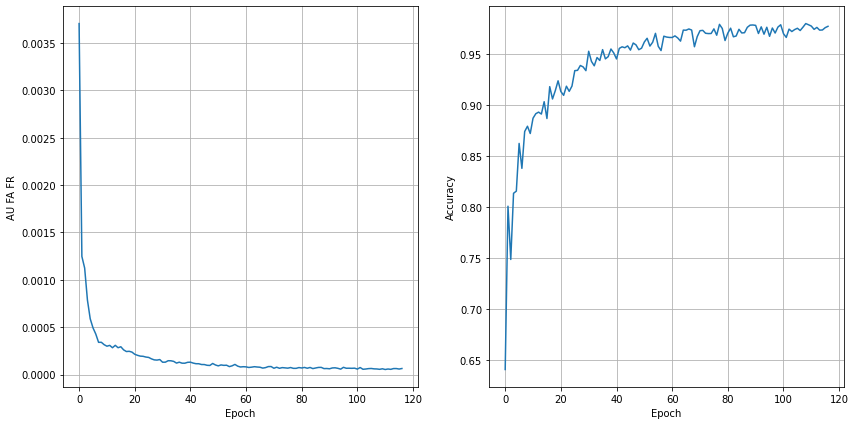

5.279489345018388e-05


 14%|█▍        | 57/405 [00:05<00:35,  9.74it/s]


KeyboardInterrupt: ignored

In [87]:
best_attention_distill_metric = attention_knowledge_distillation_train(
    attention_distill_model,
    base_model,
    opt
)

In [88]:
# не запускать, если скачал веса

attention_distill_model.load_state_dict(torch.load('best_attention_distill_model.pt'))

<All keys matched successfully>

In [153]:
attention_distill_metric, _, _ = validation(
    attention_distill_model,
    val_loader,
    melspec_val,
    'cuda'
)

100%|██████████| 102/102 [00:05<00:00, 18.70it/s]


In [90]:
print(f'Best Attention Distill AU FA FR: {attention_distill_metric: .7f}')

Best Attention Distill AU FA FR:  0.0000528


In [111]:
model_summaries['AD+KD'] = {
    'MACs': 137698,
    'Parameters': 2445,
    'Theoretical size (KB)': 9.551,
    'Real size (KB)': 13.14,
    'Metric': 0.0000528
}

In [112]:
model_summaries

{'AD+KD': {'MACs': 137698,
  'Metric': 5.28e-05,
  'Parameters': 2445,
  'Real size (KB)': 13.14,
  'Theoretical size (KB)': 9.551},
 'B': {'MACs': 1952368,
  'Metric': 2.6e-05,
  'Parameters': 70443,
  'Real size (KB)': 278.51,
  'Theoretical size (KB)': 275.168},
 'DQ+KD': {'MACs': 305167,
  'Metric': 4.61e-05,
  'Parameters': 8329,
  'Real size (KB)': 16.72},
 'DQ+KD2': {'MACs': 186924,
  'Metric': 4.72e-05,
  'Parameters': 3915,
  'Real size (KB)': 12.16},
 'KD': {'MACs': 305167,
  'Metric': 4.59e-05,
  'Parameters': 8329,
  'Real size (KB)': 36.07,
  'Theoretical size (KB)': 32.535},
 'KD2': {'MACs': 186924,
  'Metric': 4.77e-05,
  'Parameters': 3915,
  'Real size (KB)': 18.76,
  'Theoretical size (KB)': 15.293}}

# Attention Distillation + Dark Knowledge Distillation + Dynamic Quantization

In [95]:
dynamic_quant_attention_distill_model = torch.quantization.quantize_dynamic(
    attention_distill_model.cpu(), 
    {nn.GRU, nn.Linear},
    dtype=torch.qint8
)

In [96]:
torch.save(dynamic_quant_attention_distill_model.state_dict(),
           'dynamic_quant_attention_distill_model.pt')

In [97]:
dynamic_quant_attention_distill_metric, _, _ = validation(
    dynamic_quant_attention_distill_model,
    val_loader,
    cpu_melspec,
    'cpu'
)

100%|██████████| 102/102 [00:08<00:00, 11.40it/s]


In [98]:
print(f'Best Attention Distillation + Dynamic Quantization AU FA FR: {dynamic_quant_attention_distill_metric: .7f}')

Best Attention Distillation + Dynamic Quantization AU FA FR:  0.0000521


In [113]:
model_summaries['DQ+AD+KD'] = {
    'MACs': 137698,
    'Parameters': 2445,
    'Real size (KB)': 10.28,
    'Metric': 0.0000521
}

Так, ну эта модель меньше в 278.51 / 10.28 ~= 27 раз и быстрее в 1952368 / 137698 ~= 14 раз. Видимо лучше я уже не сделаю.

In [114]:
model_summaries

{'AD+KD': {'MACs': 137698,
  'Metric': 5.28e-05,
  'Parameters': 2445,
  'Real size (KB)': 13.14,
  'Theoretical size (KB)': 9.551},
 'B': {'MACs': 1952368,
  'Metric': 2.6e-05,
  'Parameters': 70443,
  'Real size (KB)': 278.51,
  'Theoretical size (KB)': 275.168},
 'DQ+AD+KD': {'MACs': 137698,
  'Metric': 5.21e-05,
  'Parameters': 2445,
  'Real size (KB)': 10.28},
 'DQ+KD': {'MACs': 305167,
  'Metric': 4.61e-05,
  'Parameters': 8329,
  'Real size (KB)': 16.72},
 'DQ+KD2': {'MACs': 186924,
  'Metric': 4.72e-05,
  'Parameters': 3915,
  'Real size (KB)': 12.16},
 'KD': {'MACs': 305167,
  'Metric': 4.59e-05,
  'Parameters': 8329,
  'Real size (KB)': 36.07,
  'Theoretical size (KB)': 32.535},
 'KD2': {'MACs': 186924,
  'Metric': 4.77e-05,
  'Parameters': 3915,
  'Real size (KB)': 18.76,
  'Theoretical size (KB)': 15.293}}

# Base + Dynamic Quantization

In [ ]:
dynamic_quant_base_model = torch.quantization.quantize_dynamic(
    base_model.cpu(), 
    {nn.GRU, nn.Linear},
    dtype=torch.qint8
)

In [ ]:
torch.save(dynamic_quant_base_model.state_dict(), 'dynamic_quant_base_model.pt')

In [ ]:
dynamic_quant_base_metric, _, _ = validation(
    dynamic_quant_base_model,
    val_loader,
    cpu_melspec,
    'cpu'
)

100%|██████████| 102/102 [00:09<00:00, 10.33it/s]


In [ ]:
print(f'Best Base Dynamic Quantization AU FA FR: {dynamic_quant_base_metric: .7f}')

Best Base Dynamic Quantization AU FA FR:  0.0000274


In [115]:
model_summaries['DQ+B'] = {
    'MACs': 1952368,
    'Parameters': 70443,
    'Real size (KB)': 80.6,
    'Metric': 0.0000274
}

In [116]:
model_summaries

{'AD+KD': {'MACs': 137698,
  'Metric': 5.28e-05,
  'Parameters': 2445,
  'Real size (KB)': 13.14,
  'Theoretical size (KB)': 9.551},
 'B': {'MACs': 1952368,
  'Metric': 2.6e-05,
  'Parameters': 70443,
  'Real size (KB)': 278.51,
  'Theoretical size (KB)': 275.168},
 'DQ+AD+KD': {'MACs': 137698,
  'Metric': 5.21e-05,
  'Parameters': 2445,
  'Real size (KB)': 10.28},
 'DQ+B': {'MACs': 1952368,
  'Metric': 2.74e-05,
  'Parameters': 70443,
  'Real size (KB)': 80.6},
 'DQ+KD': {'MACs': 305167,
  'Metric': 4.61e-05,
  'Parameters': 8329,
  'Real size (KB)': 16.72},
 'DQ+KD2': {'MACs': 186924,
  'Metric': 4.72e-05,
  'Parameters': 3915,
  'Real size (KB)': 12.16},
 'KD': {'MACs': 305167,
  'Metric': 4.59e-05,
  'Parameters': 8329,
  'Real size (KB)': 36.07,
  'Theoretical size (KB)': 32.535},
 'KD2': {'MACs': 186924,
  'Metric': 4.77e-05,
  'Parameters': 3915,
  'Real size (KB)': 18.76,
  'Theoretical size (KB)': 15.293}}

# Graphs

In [151]:
plt.style.use('ggplot')

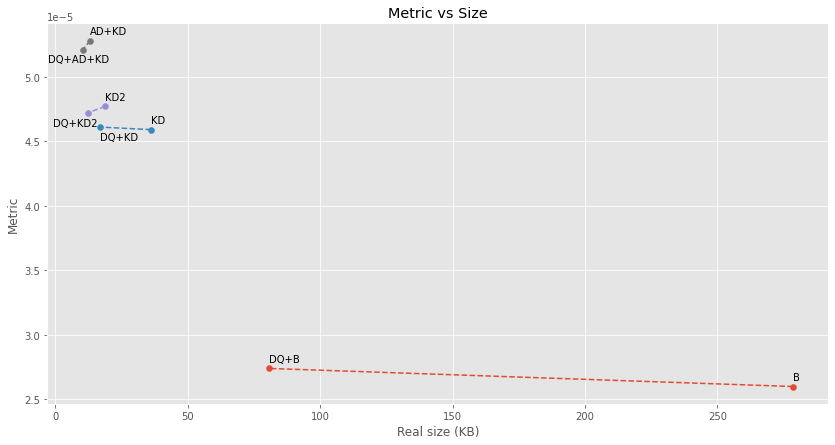

In [131]:
def get_value(model_names, value_names):
  result = []
  for value_name in value_names:
    value_list = []
    for model_name in model_names:
      value_list.append(model_summaries[model_name][value_name])
    result.append(value_list)
  return result

value_names = ['Real size (KB)', 'Metric']

pairs = [('B', 'DQ+B'),
         ('KD', 'DQ+KD'),
         ('KD2', 'DQ+KD2'),
         ('AD+KD', 'DQ+AD+KD')]

plt.figure(figsize=(14, 7))

for pair in pairs:
  sizes, metrics = get_value(pair, value_names)
  plt.scatter(sizes, metrics)
  plt.plot(sizes, metrics, linestyle='dashed')
  for i in range(len(sizes)):
    if pair[i] in ['DQ+AD+KD', 'DQ+KD2']:
      plt.annotate(pair[i], (sizes[i] - 13, metrics[i] - 1e-6), fontsize=10)
    elif pair[i] == 'DQ+KD':
      plt.annotate(pair[i], (sizes[i], metrics[i] - 1e-6), fontsize=10)
    else:
      plt.annotate(pair[i], (sizes[i], metrics[i] + 5e-7), fontsize=10)

plt.xlabel('Real size (KB)')
plt.ylabel('Metric')
plt.title('Metric vs Size')
plt.show()

Тут можно посмотреть, как квантизация влияет на размер модели в зависимости от того, насколько большой у неё изначально размер. Любопытно. Получается, что уже небольшие модели сжимаются не так сильно.

Также можно посмотреть на то, как теряется качество, но здесь что-то сказать сложно, потому что в случае дистилляции модель потеряла очень мало в качестве, а в остальных случаях заметно больше. 

При этом качество уменьшается в пределах разумного, и в то же время размер уменьшается сильно. Поэтому вывод - квантизация мастхэв.

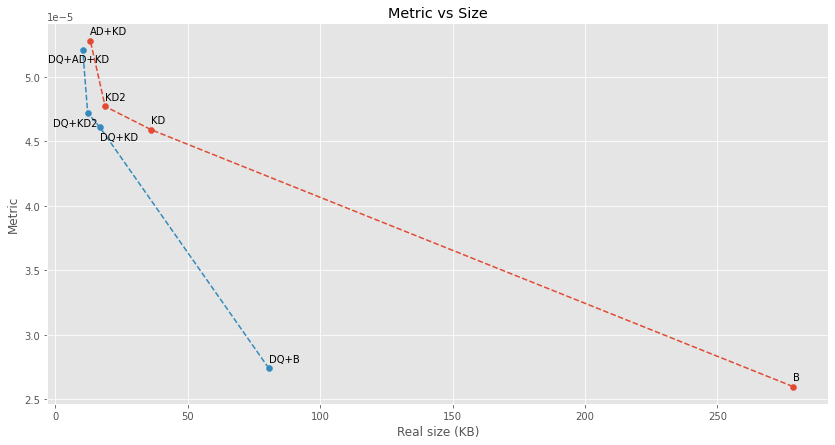

In [132]:
pairs = [('B', 'KD', 'KD2', 'AD+KD'),
         ('DQ+B', 'DQ+KD', 'DQ+KD2', 'DQ+AD+KD')]

plt.figure(figsize=(14, 7))

for pair in pairs:
  sizes, metrics = get_value(pair, value_names)
  plt.scatter(sizes, metrics)
  plt.plot(sizes, metrics, linestyle='dashed')
  for i in range(len(sizes)):
    if pair[i] in ['DQ+AD+KD', 'DQ+KD2']:
      plt.annotate(pair[i], (sizes[i] - 13, metrics[i] - 1e-6), fontsize=10)
    elif pair[i] == 'DQ+KD':
      plt.annotate(pair[i], (sizes[i], metrics[i] - 1e-6), fontsize=10)
    else:
      plt.annotate(pair[i], (sizes[i], metrics[i] + 5e-7), fontsize=10)

plt.xlabel('Real size (KB)')
plt.ylabel('Metric')
plt.title('Metric vs Size')
plt.show()

Здесь попытался выделить влияние дистилляции. Видно, что основной вклад в сжатие сделала именно дистилляция (это даже без учета того, что только дистилляция увеличила скорость в MACs).

На самом деле, был очень приятно удивлен таким хорошим результатам дистилляции. Вариант намного более долгий по сравнению с квантизацией (нужно много эпох), но буст очень хороший. Ещё больше мастхэв.

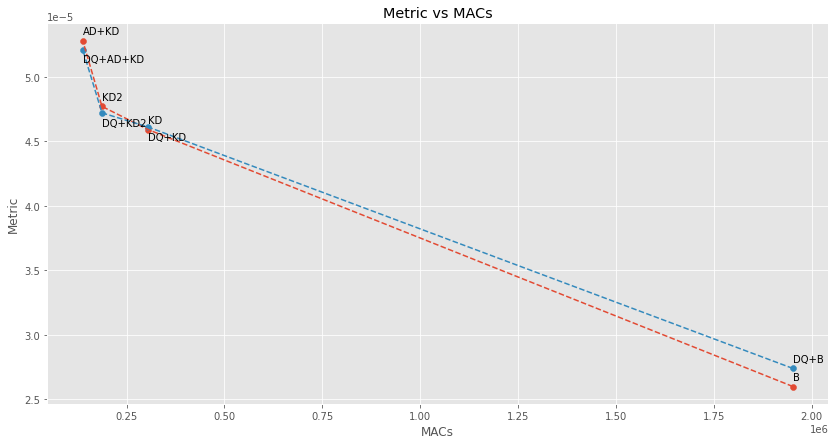

In [134]:
value_names = ['MACs', 'Metric']

pairs = [('B', 'KD', 'KD2', 'AD+KD'),
         ('DQ+B', 'DQ+KD', 'DQ+KD2', 'DQ+AD+KD')]

plt.figure(figsize=(14, 7))

for pair in pairs:
  sizes, metrics = get_value(pair, value_names)
  plt.scatter(sizes, metrics)
  plt.plot(sizes, metrics, linestyle='dashed')
  for i in range(len(sizes)):
    if pair[i] in ['DQ+AD+KD', 'DQ+KD2']:
      plt.annotate(pair[i], (sizes[i] - 13, metrics[i] - 1e-6), fontsize=10)
    elif pair[i] == 'DQ+KD':
      plt.annotate(pair[i], (sizes[i], metrics[i] - 1e-6), fontsize=10)
    else:
      plt.annotate(pair[i], (sizes[i], metrics[i] + 5e-7), fontsize=10)

plt.xlabel('MACs')
plt.ylabel('Metric')
plt.title('Metric vs MACs')
plt.show()

Супер малоинформативный график)))

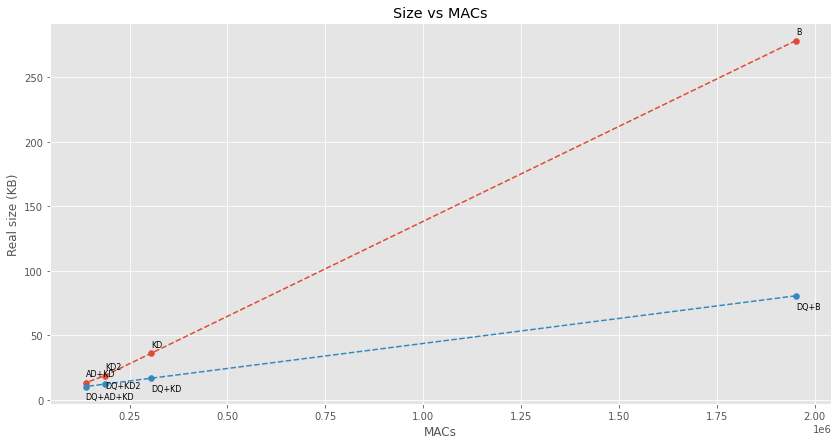

In [150]:
value_names = ['MACs', 'Real size (KB)']

pairs = [('B', 'KD', 'KD2', 'AD+KD'),
         ('DQ+B', 'DQ+KD', 'DQ+KD2', 'DQ+AD+KD')]

plt.figure(figsize=(14, 7))

for pair in pairs:
  sizes, metrics = get_value(pair, value_names)
  plt.scatter(sizes, metrics)
  plt.plot(sizes, metrics, linestyle='dashed')
  for i in range(len(sizes)):
    if pair[i] in pairs[0]:
      plt.annotate(pair[i], (sizes[i], metrics[i] + 5), fontsize=8)
    elif pair[i] == 'DQ+KD2':
      plt.annotate(pair[i], (sizes[i], metrics[i] - 3), fontsize=8)
    else:
      plt.annotate(pair[i], (sizes[i], metrics[i] - 10), fontsize=8)

plt.xlabel('MACs')
plt.ylabel('Real size (KB)')
plt.title('Size vs MACs')
plt.show()

Тут видимо можно сделать вывод, что размер и MACs модели ведут себя примерно пропорционально, только с большим коэффициентом, что логично.

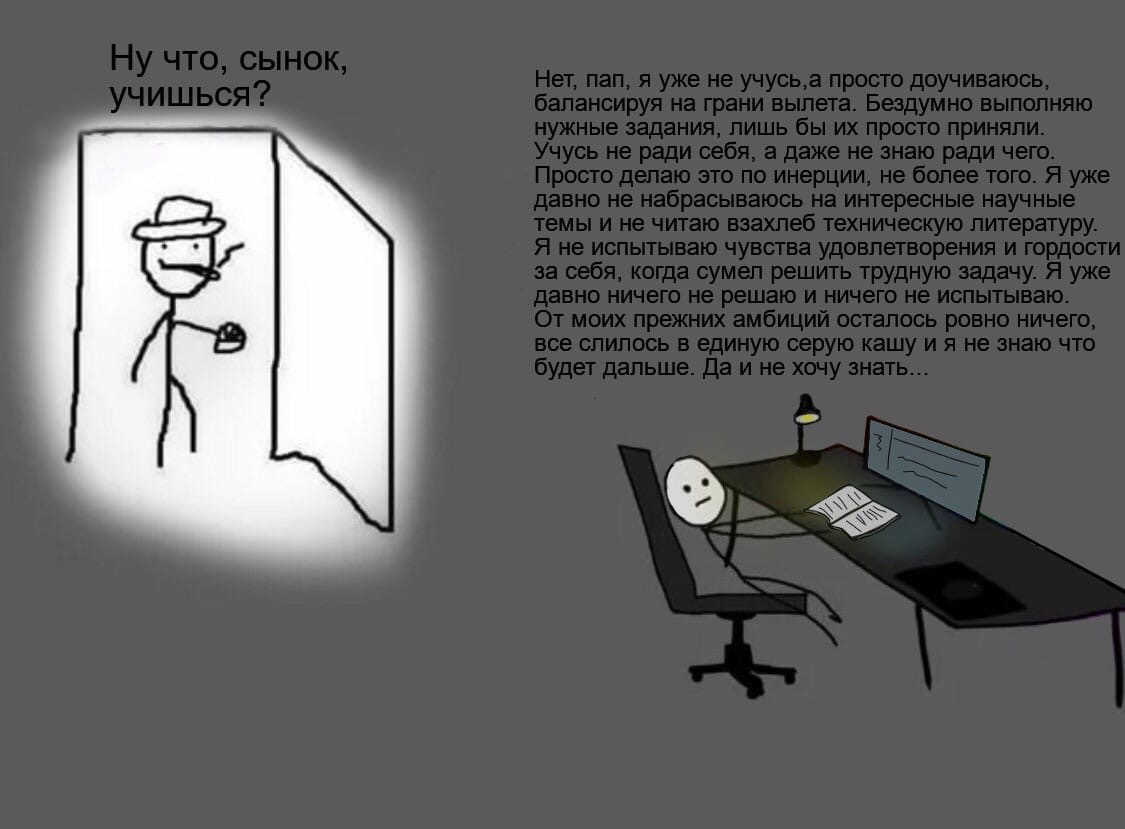